#**Multivariate Time Series Anamoly Detection Using DeepAnT**

**Importing Required Libraries**

In [83]:
import numpy as np
import pandas as pd
import torch
import time, datetime
import seaborn as sns
import os


**Converting Index of Data to Timestamps to have better analysis through dataframe plots and Resampling if required.**

In [84]:
def convert_data_to_timestamps(data_path):
    data = pd.read_csv(data_path)
    data.set_index("LOCAL_DATE", inplace=True)
    data.fillna(data.mean(), inplace=True)
    data_new = data.copy()
    data.index = pd.to_datetime(data.index, errors='coerce')

    return data, data_new

**Preparing Dataset for Model**

In [85]:
from sklearn.preprocessing import MinMaxScaler
def preprocess_data(df, lookback):
  scaled_data = MinMaxScaler(feature_range = (0,1))
  data_scaled = scaled_data.fit_transform(df)
  df.loc[:,:]=data_scaled
  new_data = df.to_numpy(copy=True)
  X = np.zeros(shape=(df.shape[0]-lookback,lookback,df.shape[1])) #df.shape[1] holding all feature apart from the first column
  Y = np.zeros(shape=(df.shape[0]-lookback,df.shape[1]))
  timestamps=[]
  for i in range(lookback-1, df.shape[0]-1):
       timestamps.append(df.index[i])
       Y[i-(lookback-1)] = new_data[i+1] # storing next value for prediction
       for j in range(i-(lookback-1), i+1):
         X[i-(lookback-1)][lookback-1-i+j] = new_data[j] # storing past lookback values for each index
  return X,Y,timestamps

The torch.nn.Linear layer performs a linear transformation on its input data, where each output neuron is a weighted sum of the input neurons, plus a bias term.
The weights (parameters) of this layer will have a shape of (40, 80) for the weight matrix and (40,) for the bias vector.
During the forward pass of the neural network, input data of shape (batch_size, 80) will be multiplied by the weight matrix and added to the bias vector to produce an output of shape (batch_size, 40).

# **DeepAnT Model**

In [86]:
class DeepAnT(torch.nn.Module): # torch.nn.Module is parent class here
  def __init__(self, lookback, features_dimension):
        super(DeepAnT, self).__init__() # calling parent class constructor and below goes the initialization code
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=lookback, out_channels=16, kernel_size=3) #outchannel - Kernel numbers and #inchannel - number of stacks similar to images (RGB-3)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=2)

        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=2)

        self.flatten_layer = torch.nn.Flatten()

        self.dense_1_layer = torch.nn.Linear(80, 40)  #80 dimension of input feature #40 dimension of output feature or number of neurons
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.25)

        self.dense_2_layer = torch.nn.Linear(40, features_dimension) # predicting all the features on the basis of past observation
        # past lookback features are like the training dataset and present set of features are the truth values.

  def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)


**For Batchwise Training and Prediction**

In [87]:
def make_train_step(model, loss_fn, optimizer):

    def train_step(x, y):
        model.train()  # Set the model to training mode (affects layer like dropout and batch normalization) # the training doesn't starts here
        yhat = model(x)  # Forward pass: compute predicted y by passing x to the model
        loss = loss_fn(y, yhat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update model parameters based on gradients
        optimizer.zero_grad()  # Clear the gradients of all optimized variables to prepare for next batch
        return loss.item()  # Return the loss value as a Python float

    return train_step


In [88]:
def initiateModel(X,Y,epochs,lookback):
  Model = DeepAnT(lookback, data.shape[1])
  loss_fn = torch.nn.MSELoss(reduction ='mean')
  optimizer = torch.optim.Adam(Model.parameters(), lr=1e-5)
  train_step = make_train_step(Model, loss_fn, optimizer)
  train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(Y.astype(np.float32)))
  train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
  Number_of_epochs = epochs
  for epoch in range(Number_of_epochs):
    loss_sum = 0.0
    counter = 0
    for x_batch, y_batch in train_loader:
      loss_train = train_step(x_batch, y_batch)
      loss_sum +=loss_train
      counter +=1
    print(f"Epoch {epoch+1}, Loss: {loss_sum/counter}")
  predicted = Model(torch.tensor(X.astype(np.float32))).detach().numpy()  # Model() calls the forward pass to calculate predicted values of the batch
  loss = np.linalg.norm(predicted - Y, axis=1)
  return loss.reshape(len(loss),1)

**Getting Processed Data and Timestamps**

In [89]:
file_path = "/content/Canadian_climate_history.csv"
lookback = 10
data, _data = convert_data_to_timestamps(file_path)
X,Y,timestamps = preprocess_data(data, lookback)

In [90]:
epochs = 50
loss = initiateModel(X,Y,epochs,lookback)

Epoch 1, Loss: 0.2052408549179775
Epoch 2, Loss: 0.12313656843505057
Epoch 3, Loss: 0.06456058241247413
Epoch 4, Loss: 0.04422301460600173
Epoch 5, Loss: 0.03533244694033301
Epoch 6, Loss: 0.030255535106416404
Epoch 7, Loss: 0.026503409712951783
Epoch 8, Loss: 0.023857245783791812
Epoch 9, Loss: 0.021613640449573934
Epoch 10, Loss: 0.01980036494259897
Epoch 11, Loss: 0.018403973878205214
Epoch 12, Loss: 0.0173123396192509
Epoch 13, Loss: 0.0161497237921773
Epoch 14, Loss: 0.015422441700814131
Epoch 15, Loss: 0.014579489256937755
Epoch 16, Loss: 0.013876145395479876
Epoch 17, Loss: 0.013514927653177577
Epoch 18, Loss: 0.013002284611743617
Epoch 19, Loss: 0.012605957773096884
Epoch 20, Loss: 0.012146839002394173
Epoch 21, Loss: 0.01185192208765697
Epoch 22, Loss: 0.011466025591594334
Epoch 23, Loss: 0.011285433480934304
Epoch 24, Loss: 0.010987206571301913
Epoch 25, Loss: 0.010747135630609857
Epoch 26, Loss: 0.010561100724443941
Epoch 27, Loss: 0.010354075187598922
Epoch 28, Loss: 0.0101

In [91]:
loss_df = pd.DataFrame(loss, columns = ["loss"])
loss_df.index = timestamps
loss_df.index = pd.to_datetime(loss_df.index)
loss_df["timestamp"] = timestamps
loss_df["timestamp"] = pd.to_datetime(loss_df["timestamp"])

In [92]:
loss_df

,loss,timestamp
1940-01-10,0.495087,1940-01-10
1940-01-11,0.428489,1940-01-11
1940-01-12,0.333481,1940-01-12
1940-01-13,0.609525,1940-01-13
1940-01-14,0.606997,1940-01-14
...,...,...
2019-12-27,0.249494,2019-12-27
2019-12-28,0.232918,2019-12-28
2019-12-29,0.438860,2019-12-29
2019-12-30,0.446843,2019-12-30


**Frequency Distribution of Anamoly Score**

<ipython-input-93-f392555ecda5>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(loss_df["loss"], bins=100, label="Frequency")


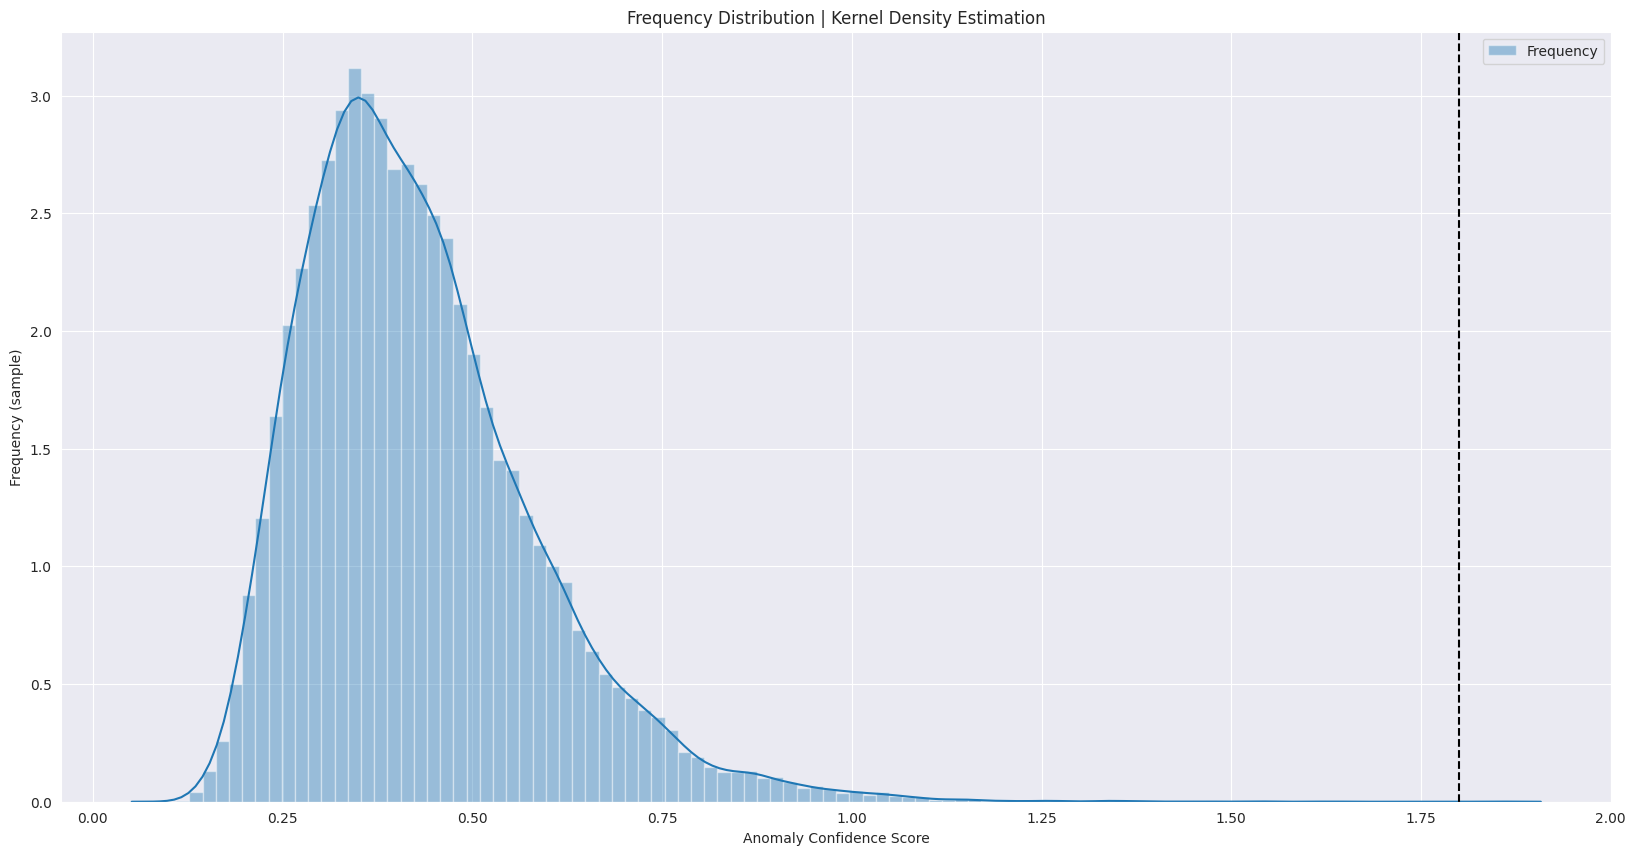

In [93]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
ax = sns.distplot(loss_df["loss"], bins=100, label="Frequency")
ax.set_title("Frequency Distribution | Kernel Density Estimation")
ax.set(xlabel='Anomaly Confidence Score', ylabel='Frequency (sample)')
plt.axvline(1.80, color="k", linestyle="--")
plt.legend()

**Detection of Anamolies using Anamoly Score**

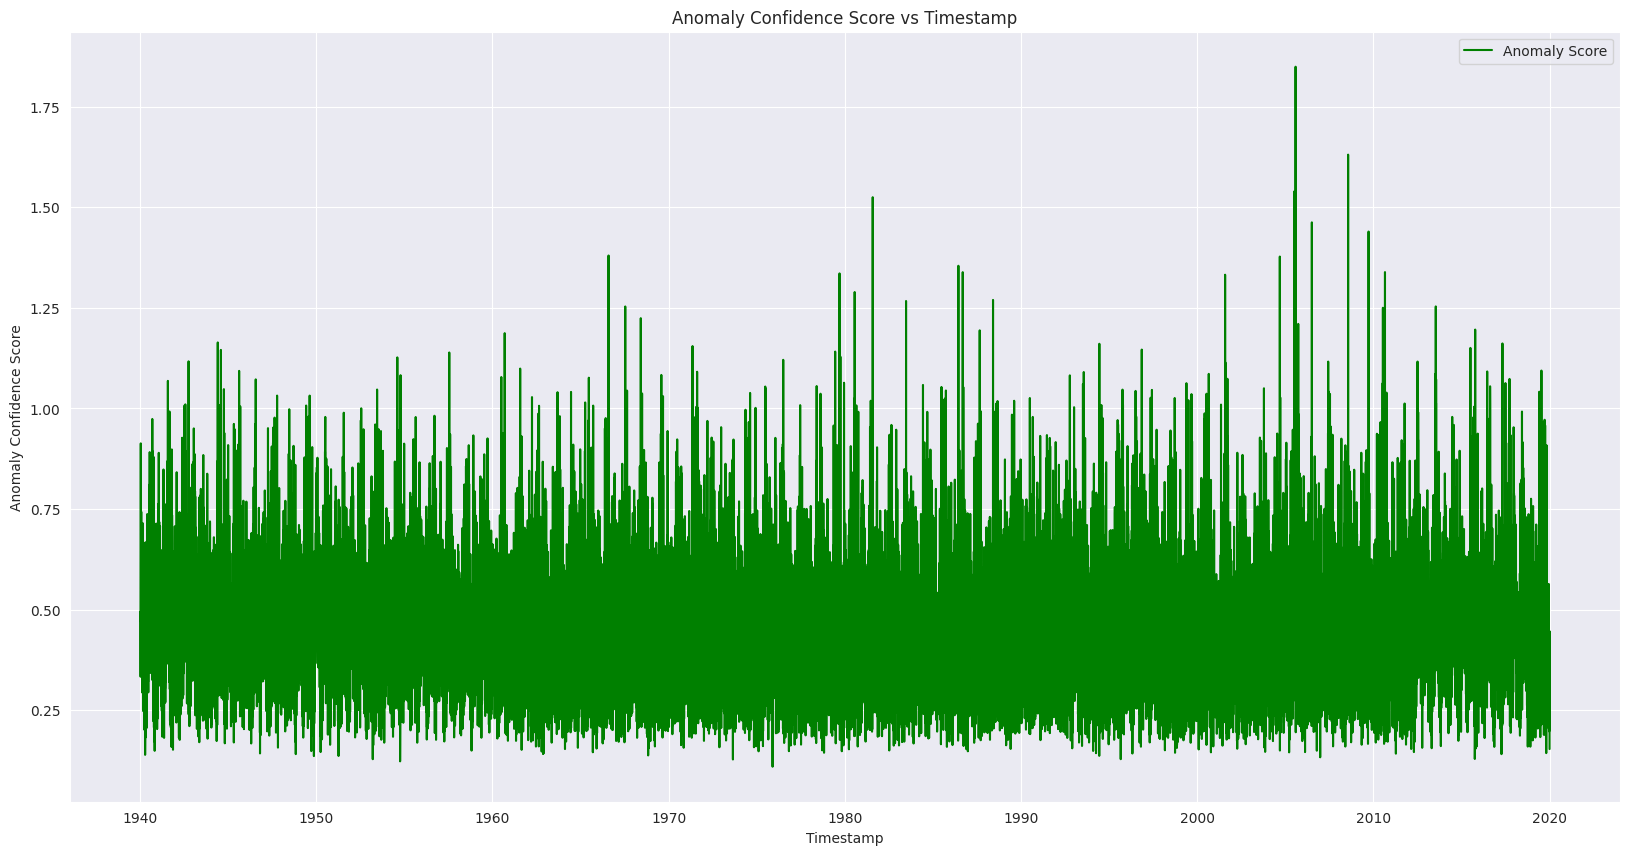

In [96]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="timestamp", y="loss", data=loss_df, color='g', label="Anomaly Score")
ax.set_title("Anomaly Confidence Score vs Timestamp")
ax.set(ylabel="Anomaly Confidence Score", xlabel="Timestamp")
plt.legend()